In [2]:
import cv2 as cv
import cv2
import matplotlib.pyplot as plt
import numpy as np

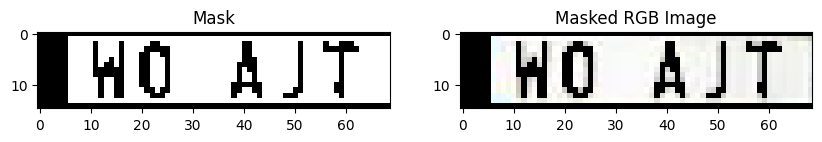

In [4]:
def create_mask(rgb_image):
    # Convert RGB image to HSV color space
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    # Define thresholds for each channel based on the provided values
    channel1_min = 0
    channel1_max = 180  # OpenCV uses 0-180 for hue
    channel2_min = 0
    channel2_max = int(0.129 * 255)
    channel3_min = int(0.781 * 255)
    channel3_max = 255
    
    # Create mask based on the defined thresholds
    mask = cv2.inRange(hsv_image, (channel1_min, channel2_min, channel3_min), (channel1_max, channel2_max, channel3_max))
    
    # Apply the mask to the original RGB image
    masked_rgb_image = cv2.bitwise_and(rgb_image, rgb_image, mask=mask)
    
    return mask, masked_rgb_image

# Example usage:
# Load RGB image
rgb_image = cv2.imread('plate.png')
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Call the function to create the mask
mask, masked_rgb_image = create_mask(rgb_image)

# Display the mask and masked RGB image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.subplot(1, 2, 2)
plt.imshow(masked_rgb_image)
plt.title('Masked RGB Image')

plt.show()


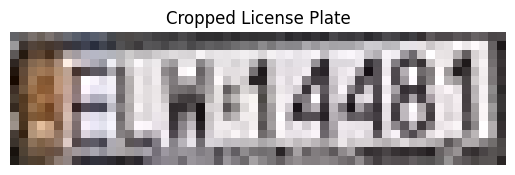

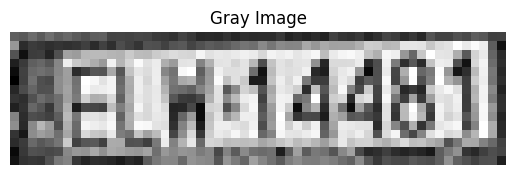

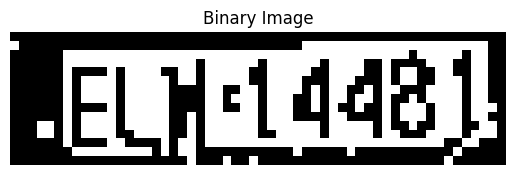

In [6]:
def show_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_images(images, titles=None):
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i] if titles else f'Image {i+1}')
        plt.axis('off')
    plt.show()

# def segment_characters(plate_image):
#     gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

#     # Prógowanie binarne
#     _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
#     # Odwrócenie kolorów (białe znaki na czarnym tle)
#     binary = cv2.bitwise_not(binary) 
#     show_image(binary, "Binary Image")

    
#     # Znajdź kontury poszczególnych znaków
#     contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     show_image(cv2.drawContours(plate_image.copy(), contours, -1, (0, 255, 0), 2), "Contours")
    
#     characters = []
#     for contour in contours:
#         (x, y, w, h) = cv2.boundingRect(contour)
#         if h > w and h > 0.5 * plate_image.shape[0]:  # Filtruj małe kontury
#             character = binary[y:y + h, x:x + w]
#             characters.append(character)
    
#     # Sortuj znaki według ich pozycji X
#     characters = sorted(characters, key=lambda char: cv2.boundingRect(char)[0])
#     return characters



# # Przykład użycia
# cropped_image = cv2.imread('plate2.png')

# if cropped_image is not None:
#     show_image(cropped_image, "Cropped License Plate")
    
#     characters = segment_characters(cropped_image)
#     print(f"Znaleziono {len(characters)} znaków:")
#     show_images(characters, [f'Character {i+1}' for i in range(len(characters))])
# else:
#     print("Tablica rejestracyjna nie została wykryta.")

cropped_image = cv2.imread('plate4.png')
show_image(cropped_image, "Cropped License Plate")
gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
show_image(gray, "Gray Image")
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
show_image(binary, "Binary Image")
# kernel = np.ones((2, 2), np.uint8)
# # binary_closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
# # show_image(binary_closed, "Closed Image")
# opened_image = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
# show_image(opened_image, "Opened Image")





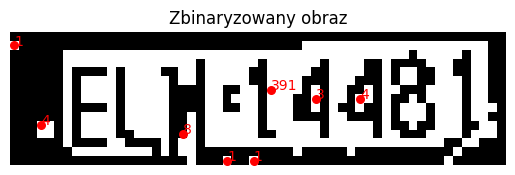

In [7]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(binary, connectivity=8)
# Wyświetlenie zbinaryzowanego obrazu
plt.imshow(binary, cmap='gray')
plt.title('Zbinaryzowany obraz')
plt.axis('off')

# Wyświetlenie składowych połączonych
for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    cx = int(centroids[i, 0])
    cy = int(centroids[i, 1])
    plt.text(cx, cy, str(area), color='red')
    plt.scatter(cx, cy, color='red', s=30)
    
plt.show()

Indeks centroidu z największym polem powierzchni: 2


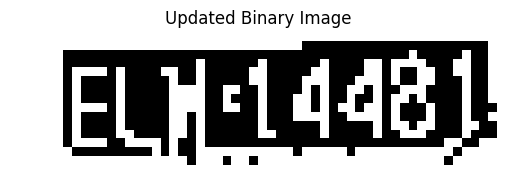

In [8]:
# Znajdź indeks centroidu z największym polem powierzchni (z pominięciem tła)
max_area_index = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1
print(f'Indeks centroidu z największym polem powierzchni: {max_area_index}')

# Pobierz współrzędne centroidu o maksymalnym polu powierzchni
max_area_centroid = centroids[max_area_index]

updated_binary_image = np.copy(binary)
# Utwórz bounding box wokół centroidu z największym polem powierzchni
x, y, w, h = stats[max_area_index, cv.CC_STAT_LEFT], stats[max_area_index, cv.CC_STAT_TOP], stats[max_area_index, cv.CC_STAT_WIDTH], stats[max_area_index, cv.CC_STAT_HEIGHT]

# Wycięcie obszaru o największym polu powierzchni z binary_image
largest_component = np.zeros_like(binary)
largest_component[labels == max_area_index] = 255

# Nowa zmienna przechowująca obszary wewnątrz bounding boxa
updated_binary_image = np.copy(largest_component)

# Iteracja przez wszystkie etykiety poza tłem
for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    cx = int(centroids[i, 0])
    cy = int(centroids[i, 1])
    
    # Sprawdzenie, czy centroid obszaru znajduje się wewnątrz bounding boxa
    if x <= cx <= x + w and y <= cy <= y + h:
        # Jeśli tak, dodaj obszar do updated_binary_image
        updated_binary_image[labels == i] = 255

inverted_updated_binary_image = cv.bitwise_not(updated_binary_image)
# Wyświetlenie zaktualizowanego binarnego obrazu
plt.imshow(inverted_updated_binary_image, cmap='gray')
plt.title('Updated Binary Image')
plt.axis('off')
plt.show()


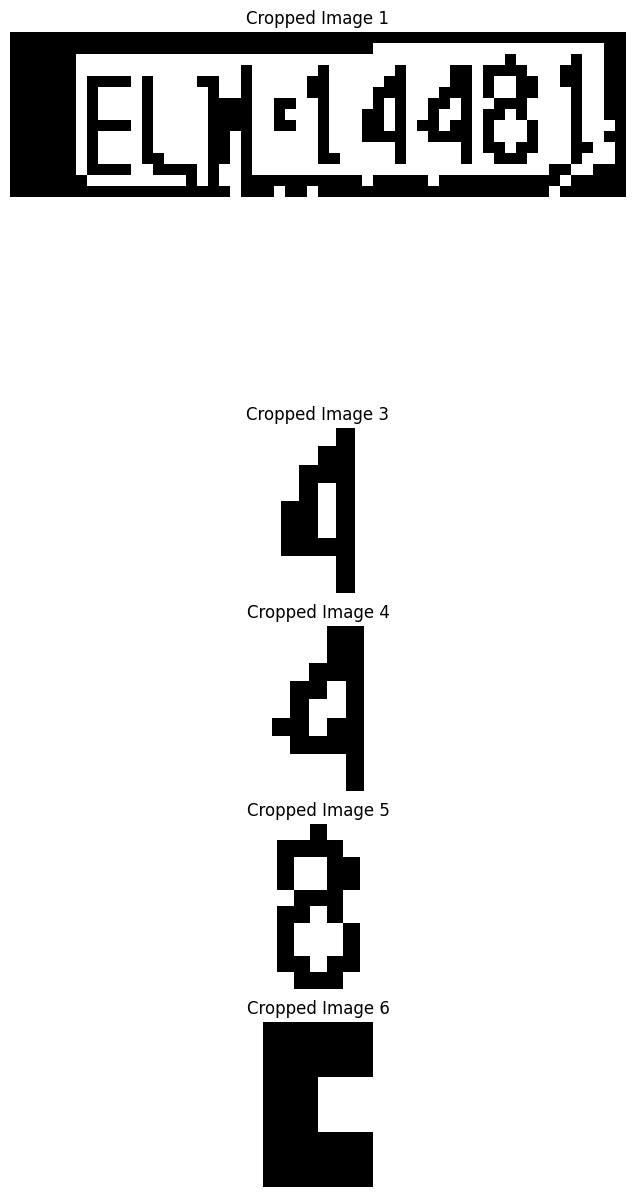

In [9]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted_updated_binary_image, connectivity=8)

# Iterate through the connected components and display each cropped area except the largest
plt.figure(figsize=(15, 15))

for i in range(1, num_labels):
    if i == max_area_index:
        continue  # Skip the largest component
    
    x, y, w, h = stats[i, cv.CC_STAT_LEFT], stats[i, cv.CC_STAT_TOP], stats[i, cv.CC_STAT_WIDTH], stats[i, cv.CC_STAT_HEIGHT]
    cropped_image = inverted_updated_binary_image[y:y+h, x:x+w]
    cropped_image = cv.bitwise_not(cropped_image)
    plt.subplot(num_labels - 1, 1, i)
    plt.imshow(cropped_image, cmap='gray')
    plt.title(f'Cropped Image {i}')
    plt.axis('off')

plt.show()

In [91]:
def split(path):
    rgb_image = cv2.imread(path)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    mask, masked_rgb_image = create_mask(rgb_image)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask, connectivity=8)
    # Znajdź indeks centroidu z największym polem powierzchni (z pominięciem tła)
    max_area_index = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

    # Pobierz współrzędne centroidu o maksymalnym polu powierzchni
    max_area_centroid = centroids[max_area_index]

    updated_binary_image = np.copy(mask)
    # Utwórz bounding box wokół centroidu z największym polem powierzchni
    x, y, w, h = stats[max_area_index, cv.CC_STAT_LEFT], stats[max_area_index, cv.CC_STAT_TOP], stats[max_area_index, cv.CC_STAT_WIDTH], stats[max_area_index, cv.CC_STAT_HEIGHT]

    # Wycięcie obszaru o największym polu powierzchni z binary_image
    largest_component = np.zeros_like(mask)
    largest_component[labels == max_area_index] = 255

    # Nowa zmienna przechowująca obszary wewnątrz bounding boxa
    updated_binary_image = np.copy(largest_component)

    # Iteracja przez wszystkie etykiety poza tłem
    for i in range(1, num_labels):
        area = stats[i, cv.CC_STAT_AREA]
        cx = int(centroids[i, 0])
        cy = int(centroids[i, 1])
        
        # Sprawdzenie, czy centroid obszaru znajduje się wewnątrz bounding boxa
        if x <= cx <= x + w and y <= cy <= y + h:
            # Jeśli tak, dodaj obszar do updated_binary_image
            updated_binary_image[labels == i] = 255

    inverted_updated_binary_image = cv.bitwise_not(updated_binary_image)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted_updated_binary_image, connectivity=8)

    # Iterate through the connected components and display each cropped area except the largest
    plt.figure(figsize=(15, 15))

    for i in range(1, num_labels):
        if i == max_area_index:
            continue  # Skip the largest component
        
        x, y, w, h = stats[i, cv.CC_STAT_LEFT], stats[i, cv.CC_STAT_TOP], stats[i, cv.CC_STAT_WIDTH], stats[i, cv.CC_STAT_HEIGHT]
        cropped_image = inverted_updated_binary_image[y:y+h, x:x+w]
        cropped_image = cv.bitwise_not(cropped_image)
        print(cropped_image)
        plt.subplot(num_labels - 1, 1, i)
        plt.imshow(cropped_image, cmap='gray')
        plt.title(f'Cropped Image {i}')
        plt.axis('off')
        cv2.imwrite(f'{path}_croped_{i}.png', cropped_image)
    plt.show()
    
    
    

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


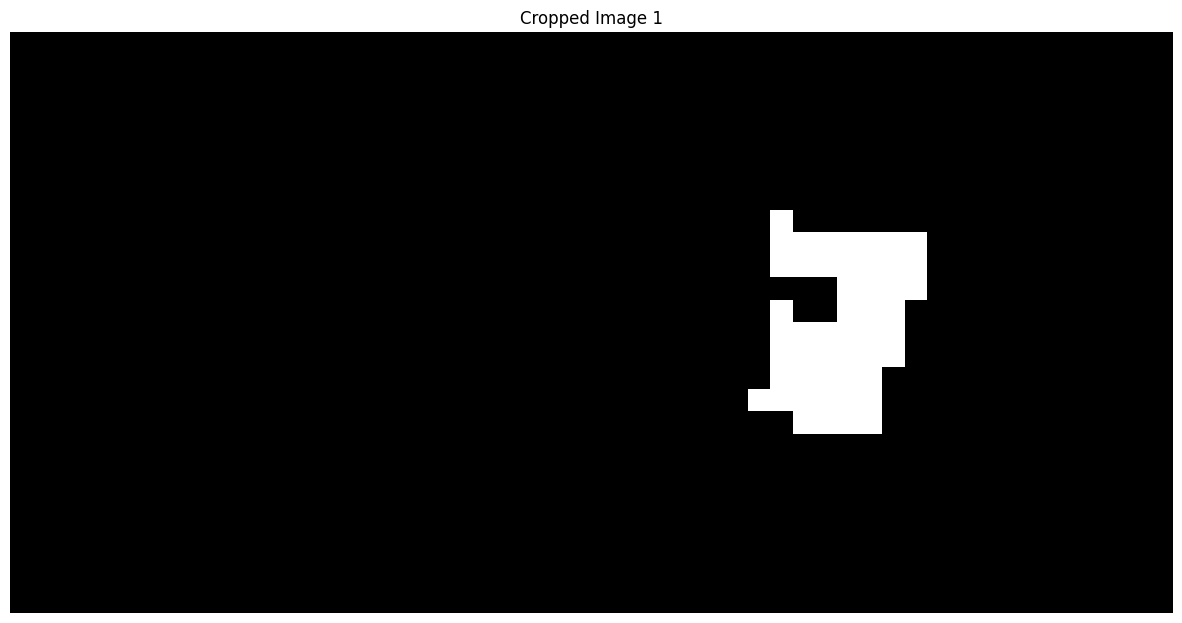

In [94]:
split("plate2.png")

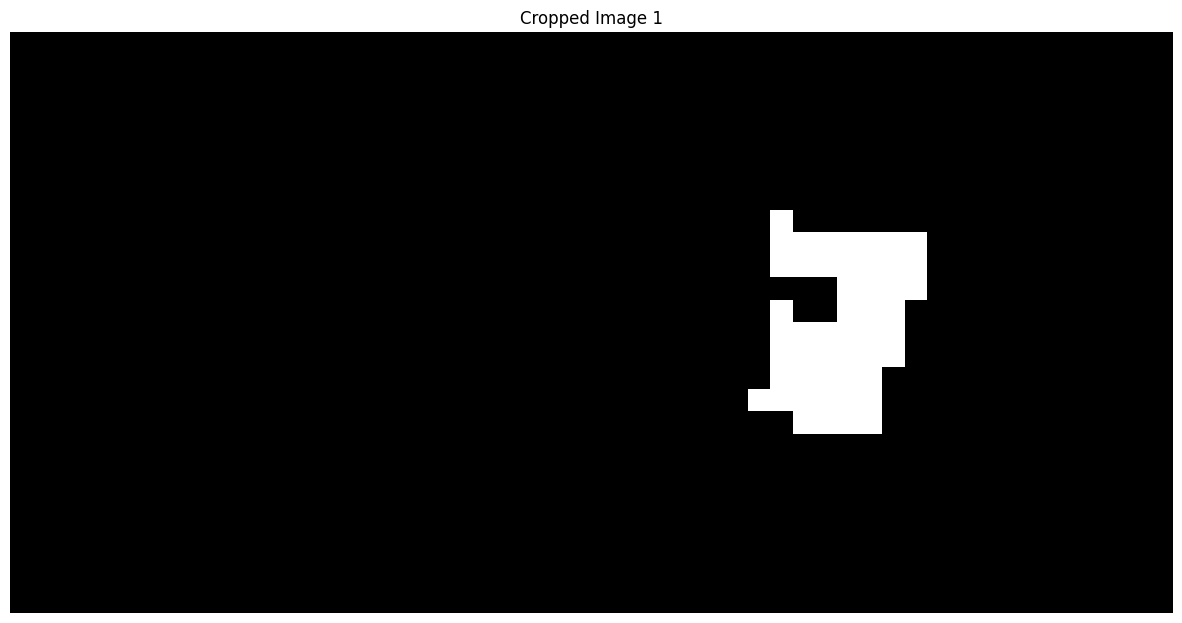

In [16]:
split("plate2.png")

In [8]:
split("plate3.png")

ValueError: attempt to get argmax of an empty sequence

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255   0
    0 255 255   0   0 255 255 255 255   0   0 255 255 255 255 255   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255 25

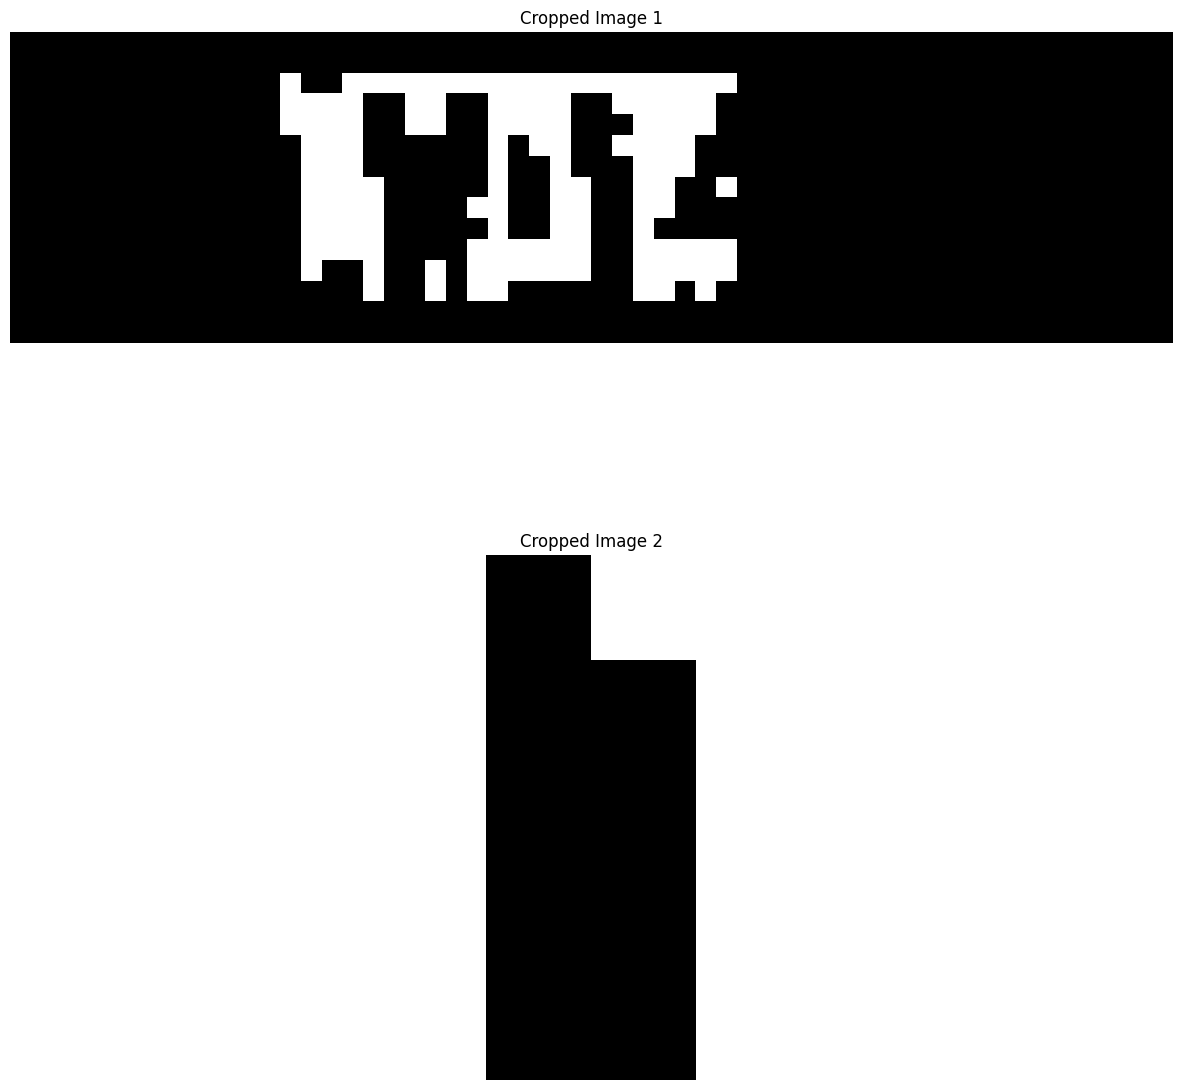

In [9]:
split("plate4.png")

In [10]:
from tensorflow.config.experimental import list_physical_devices,set_memory_growth
# Get the list of GPUs
gpus = list_physical_devices('GPU')

if gpus:
    try:
        # Allow GPU memory growth
        for gpu in gpus:
            set_memory_growth(gpu, True)
        print("GPU memory growth set successfully.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available.")

2024-05-28 10:23:18.317619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 10:23:19.536065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU memory growth set successfully.


2024-05-28 10:23:20.468531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 10:23:20.550882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 10:23:20.550969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


https://www.tensorflow.org/tutorials/images/classification

In [95]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Wczytywanie danych z katalogu
data_dir = 'data_classificator'
batch_size = 32
img_height = 28
img_width = 28

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode='grayscale',  # Ustawienie na obrazy jednokanałowe
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode='grayscale',  # Ustawienie na obrazy jednokanałowe
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 720 files belonging to 36 classes.
Using 576 files for training.
Found 720 files belonging to 36 classes.
Using 144 files for validation.


In [96]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


2024-05-28 09:00:51.787465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


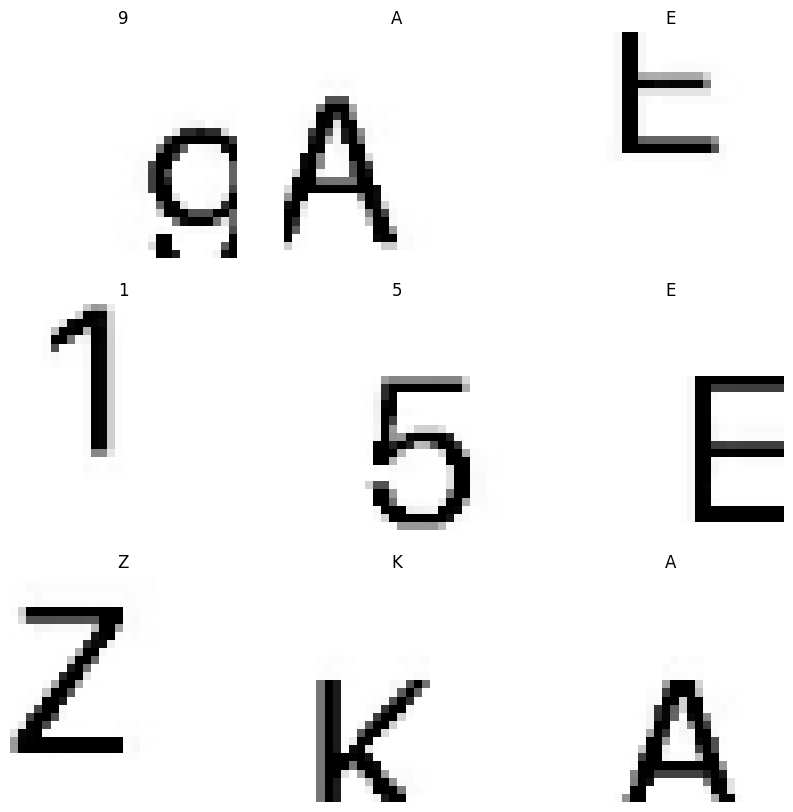

In [98]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [99]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 28, 28, 1)
(32,)


In [123]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing.image import RandomShear
# https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = tf.keras.Sequential([
    #RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.03),
    RandomZoom(0.2),
    RandomShear(0.2),
])

ImportError: cannot import name 'RandomShear' from 'tensorflow.keras.preprocessing.image' (/home/user/.local/lib/python3.10/site-packages/keras/_tf_keras/keras/preprocessing/image/__init__.py)

2024-05-28 09:26:01.060033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


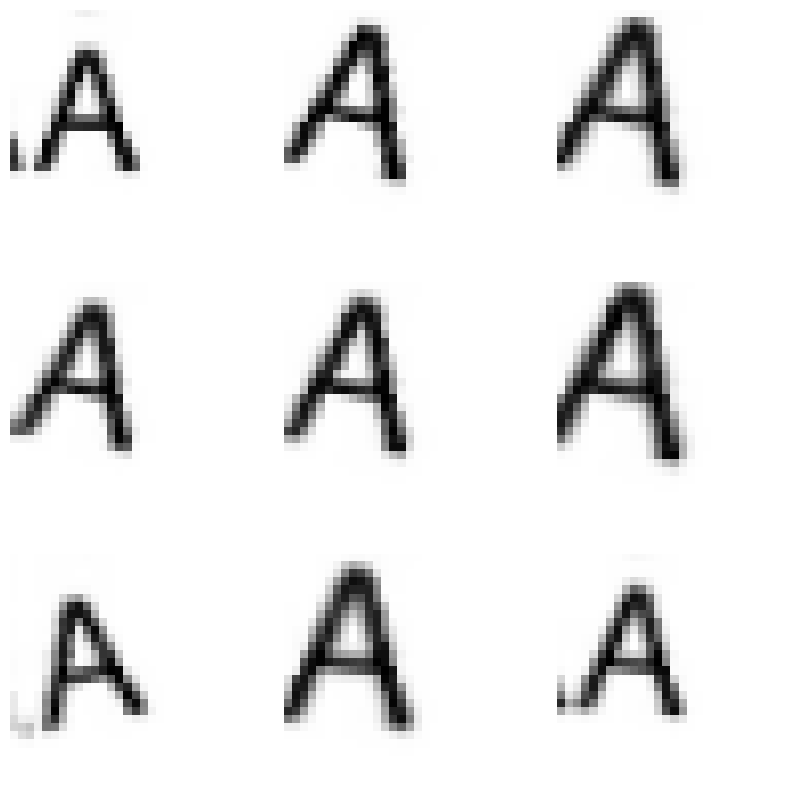

In [115]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"),cmap='gray')
    plt.axis("off")

In [101]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Definiowanie zmiennych
kernel_regularizer = regularizers.l2(0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
loss_function = 'sparse_categorical_crossentropy'

model = models.Sequential([
    layers.Resizing(img_height, img_width),
    layers.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=kernel_regularizer, input_shape=(img_height, img_width, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=kernel_regularizer),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=kernel_regularizer),
    layers.BatchNormalization(),
    #layers.MaxPooling2D((2, 2)),  # MaxPooling tylko raz po serii warstw konwolucyjnych
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=kernel_regularizer),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

model.summary()


/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_12 (Resizing)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_12 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [102]:
# Definiowanie callbacków
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    f"models/best_model_{now}.keras", 
    monitor="val_accuracy", 
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.1, 
    patience=5)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

epochs = 300

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs, 
    callbacks=callbacks
)

# Ocena modelu
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy*100:.2f}%")

Epoch 1/300


2024-05-28 09:01:28.172315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_20_1/dropout_28_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.0194 - loss: 833.6221 - val_accuracy: 0.0208 - val_loss: 253.8032 - learning_rate: 0.1000
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.0308 - loss: 174.0471 - val_accuracy: 0.0347 - val_loss: 247.7499 - learning_rate: 0.1000
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.0281 - loss: 132.9109 - val_accuracy: 0.0000e+00 - val_loss: 106.8594 - learning_rate: 0.1000
Epoch 4/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.0399 - loss: 100.8067 - val_accuracy: 0.0278 - val_loss: 157.5838 - learning_rate: 0.1000
Epoch 5/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.0198 - loss: 93.0093 - val_accuracy: 0.0000e+00 - val_loss: 68.8579 - learning_rate: 0.1000
Epoch 6/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.0349 - loss: 93.3314 - val_accuracy: 0.0278 - val_loss: 116.0801 - learning_rate: 0.1000
Epoch 7/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.02

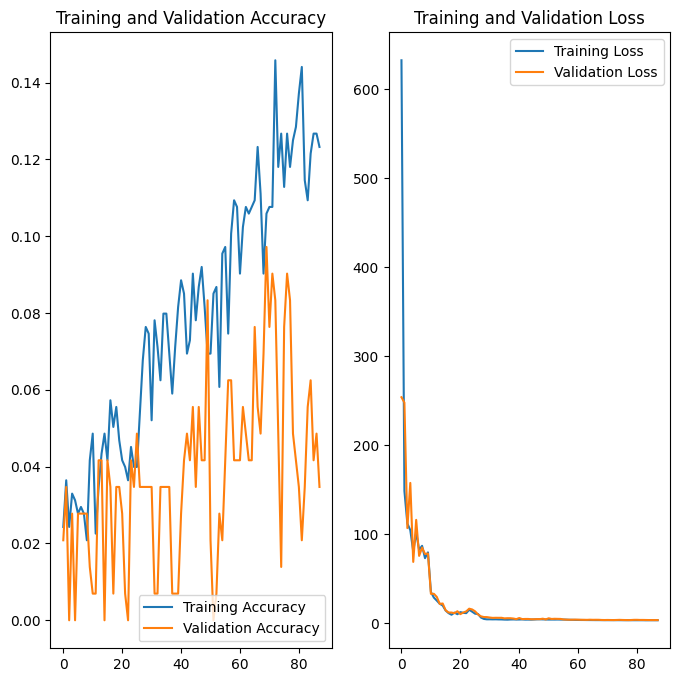

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [104]:
path="plate.png_croped_2.png"
img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_36" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (1, 28, 28, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 28, 28, 3), dtype=float32)
  • training=False
  • mask=None